# Portions Classification Task
## Data Preparation

In [2]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.cuda

In [8]:
base_dir = os.path.join('C:\\Users\\rotem.geva\\PycharmProjects\\GlycemicLoad\\Portions Estimation\\data\\raw')
data_path = os.path.join(base_dir, 'nutrition5k_dataset_metadata_dish_metadata_cafe1.csv')
data = pd.read_csv(data_path)
data.head()

C:\Users\rotem.geva\AppData\Local\Temp\ipykernel_5928\2444160089.py:3: DtypeWarning: Columns (230,231,237,238) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


,dish_1561662216,300.794281,193,12.387489,28.21829,18.63397,ingr_0000000508,soy sauce,3.398568,1.80124104,...,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243
0,dish_1562688426,137.569992,88,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dish_1561662054,419.438782,292,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dish_1562008979,382.936646,290,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dish_1560455030,20.590000,103,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1558372433,74.360001,143,0.286000,0.429000,20.020000,ingr_0000000453,deprecated,143.000000,74.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def extract_ingredients(row) -> list:
    """
    This function extracts the ingredients from the Nutrition5k dataset.
    :param row: a given row from Nutrition5k dataset.
    """
    ingredients = []
    for i in range(len(row) - 1):
        current_value = row[i]
        if type(current_value) is str:
            if current_value.startswith('ingr'):
                next_value = row[i + 1]
                if next_value not in ingredients:
                    ingredients.append(next_value)
    return ingredients

In [10]:
def extract_ingredient_content(row, ingredient, mode) -> str or None:
    """
    This function extracts the nutritional content of an ingredient from a row.
    :param row: contains ingredients from a row.
    :param ingredient: name of the ingredient.
    :param mode: mass or carbs.
    :return: nutritional content of the ingredient.
    """
    add = 0
    match mode:
        case 'mass':
            add = 1
        case 'carbs':
            add = 4
    ls = row.tolist()
    index = ls.index(ingredient)
    if index + add < len(ls):
        return ls[index + add]

In [17]:
def find_dominate_ingredient(row) -> tuple:
    ingredients = extract_ingredients(row)
    ingredient_masses = {ing: extract_ingredient_content(row, ing, 'mass') for ing in ingredients}
    dominate_ingredient = max(ingredient_masses, key=ingredient_masses.get)
    max_mass = ingredient_masses[dominate_ingredient]
    for ingredient, mass in ingredient_masses.items():
        if ingredient != dominate_ingredient and max_mass < 2 * mass:
            return None, 0  # No dominant ingredient

    return dominate_ingredient, max_mass

In [19]:
def create_dataset(data: pd.DataFrame) -> None:
    res = pd.DataFrame(columns=['dish_id', 'ingredients', 'total_mass'])
    for index, row in data.iterrows():
        ingredients = extract_ingredients(row)
        if 0 < len(ingredients) < 1: # There is only a single ingredient in the dish
            total_mass = extract_ingredient_content(row, ingredients[0], 'mass')
            new_data_row = {'dish_id': row.iloc[0], 'ingredients': ingredients, 'total_mass': total_mass}
        else:
            ingredient, ingredient_mass = find_dominate_ingredient(row)
            if ingredient is not None and ingredient_mass != 0:
                new_data_row = {'dish_id': row.iloc[0], 'ingredients': ingredient, 'total_mass': ingredient_mass}
        res.loc[len(res)] = new_data_row
    res.to_csv('portions_classification_dataset.csv', index=False)

create_dataset(data)

C:\Users\rotem.geva\AppData\Local\Temp\ipykernel_5928\3065296541.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_value = row[i]
C:\Users\rotem.geva\AppData\Local\Temp\ipykernel_5928\3065296541.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_value = row[i + 1]
C:\Users\rotem.geva\AppData\Local\Temp\ipykernel_5928\3065296541.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_value = row[i]
C:\Users\rotem

In [56]:
processed_dataset = os.path.join(base_dir, 'portions_classification_dataset.csv')
processed_dataset_df = pd.read_csv(processed_dataset)
print(processed_dataset_df.head())
print(processed_dataset_df.describe())

           dish_id dominate_ingredient  total_mass [g]
0  dish_1564415571          egg whites           595.0
1  dish_1566920365          egg whites           570.0
2  dish_1566920339          egg whites           570.0
3  dish_1566920304          egg whites           570.0
4  dish_1566316757          egg whites           563.0
       total_mass [g]
count     2787.000000
mean       101.279640
std         82.135979
min          1.000000
25%         49.000000
50%         79.000000
75%        126.000000
max        595.000000


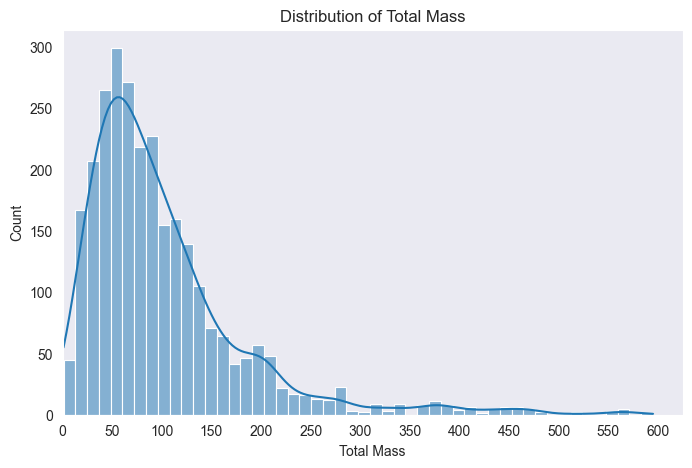

In [44]:
plt.figure(figsize=(8,5))
sns.histplot(processed_dataset_df['total_mass [g]'], bins=50, kde=True)
plt.xlabel('Total Mass')
plt.ylabel('Count')
plt.xlim(0, None)
plt.grid()
plt.title("Distribution of Total Mass")
max_value = processed_dataset_df['total_mass [g]'].max()
plt.xticks(np.arange(0, max_value + 50, 50))
plt.show()

In [54]:
# Split data into 3 groups according to mass
processed_dataset_df['mass_class'] = pd.qcut(processed_dataset_df['total_mass [g]'], q=3, labels=['Low', 'Medium', 'High'])
processed_dataset_df.to_csv('processed_portions_classification.csv', index=False)
processed_dataset_df.head()

,dish_id,dominate_ingredient,total_mass [g],mass_class
0,dish_1564415571,egg whites,595.0,High
1,dish_1566920365,egg whites,570.0,High
2,dish_1566920339,egg whites,570.0,High
3,dish_1566920304,egg whites,570.0,High
4,dish_1566316757,egg whites,563.0,High


In [55]:
processed_dataset_df['mass_class'].value_counts()

mass_class
Low       940
High      924
Medium    923
Name: count, dtype: int64

# Single Ingredients Experiment

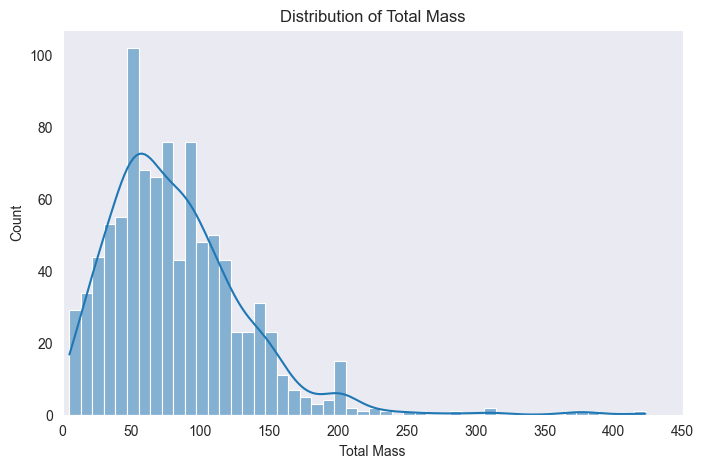

In [7]:
filepath = r"C:\Users\rotem.geva\PycharmProjects\GlycemicLoad\Portions Estimation\data\ingredients\SingleDishDataset.csv"
df = pd.read_csv(filepath)
plt.figure(figsize=(8,5))
sns.histplot(df['Mass (g)'], bins=50, kde=True)
plt.xlabel('Total Mass')
plt.ylabel('Count')
plt.xlim(0, None)
plt.grid()
plt.title("Distribution of Total Mass")
max_value = df['Mass (g)'].max()
plt.xticks(np.arange(0, max_value + 50, 50))
plt.show()

In [9]:
# Split data into 3 groups according to mass
df['mass_class'] = pd.qcut(df['Mass (g)'], q=3, labels=['0', '1', '2'])
df.to_csv('processed_single_ingr_portions_classification.csv', index=False)
df.head()

,Dish ID,Mass (g),mass_class
0,dish_1565972591,122.0,2
1,dish_1568649312,78.0,1
2,dish_1562862493,134.0,2
3,dish_1558549008,115.0,2
4,dish_1563824250,43.0,0


In [11]:
df['mass_class'].value_counts()

mass_class
0    317
2    316
1    314
Name: count, dtype: int64